# 2.Synthesizing Dataset
Synthesizing pseduo-real-world dataset from current dataset - to increase sample size for tutorial

In [25]:
import pandas as pd
import numpy as np
import os
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sklearn.impute import SimpleImputer
from sklearn.utils import resample

# --- Load dataset and clean blanks ---
df = pd.read_csv("merged_dataset.csv")
df = df.replace(r"^\s*$", np.nan, regex=True)

# Separate ID and data
df_id = df["id"]
df_data = df.drop(columns=["id"])

# --- Drop fully missing columns ---
all_nan_cols = df_data.columns[df_data.isnull().all()]
df_data = df_data.drop(columns=all_nan_cols)

# --- Store missingness pattern ---
missing_mask = df_data.isnull()

# --- Impute missing values ---
imputer = SimpleImputer(strategy="most_frequent")
df_imputed = pd.DataFrame(imputer.fit_transform(df_data), columns=df_data.columns)

# --- Categorical columns ---
categorical_columns = [
    "sex", "risk_status_mom", "income", "parent_ed", "pds_tanner_cat"
]

# --- Coerce types ---
for col in categorical_columns:
    if col in df_imputed.columns:
        df_imputed[col] = df_imputed[col].astype(str)

for col in df_imputed.columns:
    if col not in categorical_columns:
        df_imputed[col] = pd.to_numeric(df_imputed[col], errors='coerce')

# --- Metadata ---
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_imputed)

manual_dtypes = {col: "categorical" for col in categorical_columns}
for col in df_imputed.columns:
    if col not in categorical_columns:
        manual_dtypes[col] = "numerical"

for col, dtype in manual_dtypes.items():
    if col in metadata.columns:
        metadata.update_column(column_name=col, sdtype=dtype)

if os.path.exists("ctgan_metadata.json"):
    os.remove("ctgan_metadata.json")
metadata.save_to_json("ctgan_metadata.json")

# --- Fit model ---
synthesizer = CTGANSynthesizer(metadata, epochs=300)
synthesizer.fit(df_imputed)

# --- Generate data ---
n_original = df_data.shape[0]
n_to_generate = 350 - n_original
synthetic_new = synthesizer.sample(num_rows=n_to_generate)

# --- Clip known bounds ---
clip_bounds = {
    "v1_meal_total_kcal": (200, 3000),
    "v1_eah_total_kcal": (0, 2000),
    "age_yr": (2, 12),
    "bmi_percentile": (15, 95),
    "v7_bmi_percentile": (15, 95),
    "sex": (0, 1),
    "risk_status_mom": (0, 1),
    "income": (0, 5),
    "parent_ed": (0, 5),
    "pds_tanner_cat": (1, 2)
}
for col, (low, high) in clip_bounds.items():
    if col in synthetic_new.columns:
        synthetic_new[col] = pd.to_numeric(synthetic_new[col], errors='coerce')
        synthetic_new[col] = synthetic_new[col].clip(lower=low, upper=high)
        if col in categorical_columns:
            synthetic_new[col] = synthetic_new[col].round().astype(int)

# --- Enforce BMI-MVPA-Sedentary pattern ---
if set(["bmi_percentile", "v7_bmi_percentile", "mean_mvpa", "mean_sedentary"]).issubset(synthetic_new.columns):
    bmi_base = np.random.normal(50, 10, size=n_to_generate)
    mvpa_noise = np.random.normal(0, 5, size=n_to_generate)
    sed_noise = np.random.normal(0, 10, size=n_to_generate)

    synthetic_new["mean_mvpa"] = np.maximum(0, 90 - bmi_base + mvpa_noise)
    synthetic_new["mean_sedentary"] = np.maximum(100, 300 + bmi_base + sed_noise)
    synthetic_new["bmi_percentile"] = np.clip(bmi_base + np.random.normal(0, 3, size=n_to_generate), 15, 95)
    synthetic_new["v7_bmi_percentile"] = np.clip(synthetic_new["bmi_percentile"] + np.random.normal(0, 2, size=n_to_generate), 15, 95)

# --- Round fswitch and switch features to 0.25 increments ---
for col in synthetic_new.columns:
    if "switch" in col or "fswitch" in col:
        synthetic_new[col] = (synthetic_new[col] / 0.25).round() * 0.25

# --- Ensure bite/percent active eating slopes are non-negative ---
for col in synthetic_new.columns:
    if "bite" in col or "percent_active_eating" in col:
        if "intercept" not in col:
            synthetic_new[col] = synthetic_new[col].clip(lower=0)

# --- Reinject missingness ---
sampled_masks = resample(missing_mask.values, n_samples=n_to_generate, replace=True)
synthetic_with_missing = synthetic_new.mask(sampled_masks)

# --- Add noise and round to 2 decimals for numeric ---
numeric_cols = df_data.select_dtypes(include=['number']).columns
for col in numeric_cols:
    if col in synthetic_with_missing.columns:
        std = df_data[col].std()
        if pd.notna(std) and std > 0:
            synthetic_with_missing[col] += np.random.normal(0, 0.01 * std, size=n_to_generate)
        synthetic_with_missing[col] = synthetic_with_missing[col].round(2)

# --- Row validation ---
def is_valid_row(row):
    return 2 <= row.get("age_yr", 0) <= 12 and row.get("v1_meal_total_kcal", 0) <= 3500

synthetic_valid = synthetic_with_missing[synthetic_with_missing.apply(is_valid_row, axis=1)].reset_index(drop=True)

# --- Assign new IDs ---
max_real_id = df_id.max()
synthetic_valid.insert(0, "id", range(max_real_id + 1, max_real_id + 1 + len(synthetic_valid)))

# --- Restore any previously dropped columns ---
for col in all_nan_cols:
    df_data[col] = np.nan
    synthetic_valid[col] = np.nan

# --- Combine original and synthetic data ---
df_real_with_id = df_data.copy()
df_real_with_id.insert(0, "id", df_id.values)

df_combined = pd.concat([df_real_with_id, synthetic_valid], ignore_index=True)
df_combined = df_combined.sort_values("id").reset_index(drop=True)

# --- Save outputs ---
df_combined.to_csv("expanded_synthetic_data.csv", index=False)
print("✅ Final dataset saved as 'expanded_synthetic_data.csv'")
print("✅ Metadata saved as 'ctgan_metadata.json'")

c:\Users\ybr5070\.conda\envs\yolo_env\Lib\site-packages\sdv\single_table\base.py:145: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)


✅ Final dataset saved as 'expanded_synthetic_data.csv'
✅ Metadata saved as 'ctgan_metadata.json'


# 3. Missing Data Analysis

Visualizing missing data

Missingness Summary:
                       Missing Count  Missing %    Dtype
avg_sleep_frag_index            166  48.255814  float64
mean_mvpa                        50  14.534884  float64
mean_sedentary                   50  14.534884  float64
brief2_gec_p                     48  13.953488  float64
tfeq_hunger                      24   6.976744  float64
tfeq_cogcontrol                  20   5.813953  float64
cebq_avoid                       12   3.488372  float64
tfeq_disinhibition               11   3.197674  float64
income                            9   2.616279  float64
cebq_se                           8   2.325581  float64
cebq_eue                          8   2.325581  float64
cebq_eoe                          7   2.034884  float64
cebq_approach                     7   2.034884  float64
v1_eah_total_kcal                 5   1.453488  float64
cfq_pcw                           5   1.453488  float64
cfq_cwc                           5   1.453488  float64
bis                       

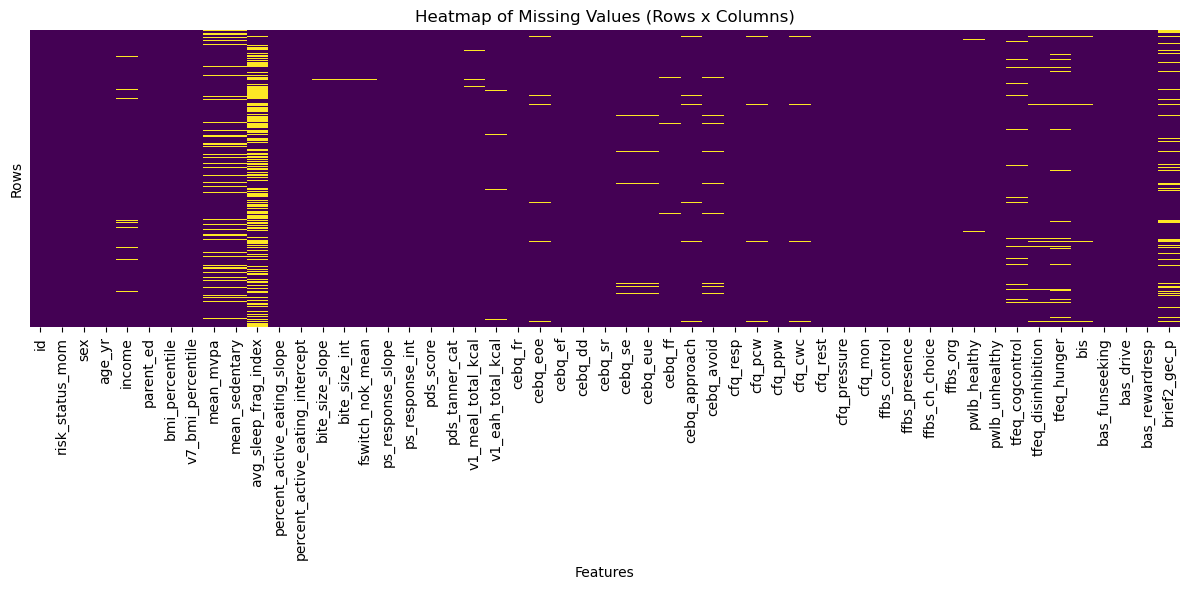

C:\Users\ybr5070\AppData\Local\Temp\ipykernel_19128\3224440277.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette="Reds_d")


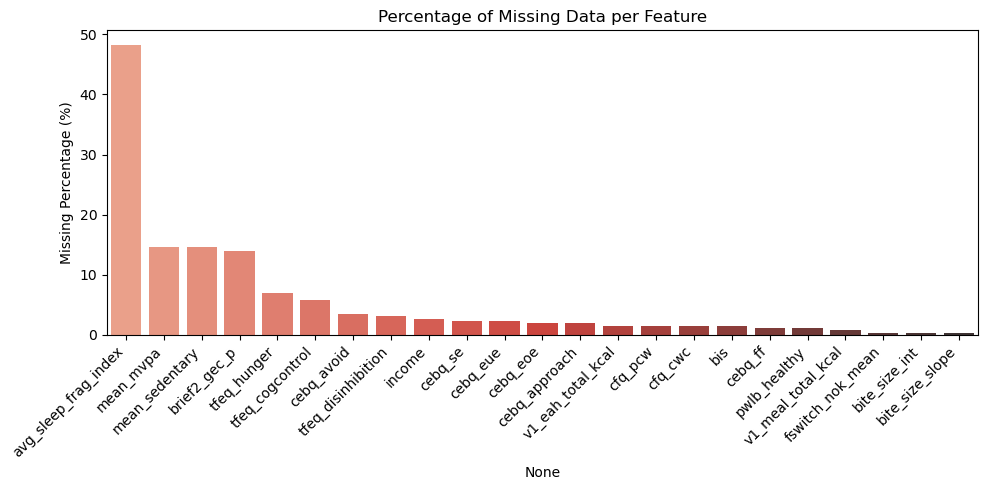

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_csv("expanded_synthetic_data.csv")  # Replace with your actual filename

# ----------------------------
# Tabular Missingness Summary
# ----------------------------
missing_summary = pd.DataFrame({
    "Missing Count": df.isnull().sum(),
    "Missing %": (df.isnull().sum() / len(df)) * 100,
    "Dtype": df.dtypes
})
missing_summary = missing_summary[missing_summary["Missing Count"] > 0]
missing_summary = missing_summary.sort_values(by="Missing %", ascending=False)
print("Missingness Summary:\n", missing_summary)

# ----------------------------
# Visualization 1: Heatmap of Missing Rows x Columns
# ----------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("Heatmap of Missing Values (Rows x Columns)")
plt.xlabel("Features")
plt.ylabel("Rows")
plt.tight_layout()
plt.show()

# ----------------------------
# Visualization 2: Missing % per Column
# ----------------------------
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=missing_percent.index, y=missing_percent.values, palette="Reds_d")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Missing Percentage (%)")
plt.title("Percentage of Missing Data per Feature")
plt.tight_layout()
plt.show()

Since there is nearly 50% missing in avg sleep fragmentation data, we are not considering that for modeling. 20-10% can be imputed but needs to be considered carefully; kNN imputation can help especially for behavior data that is variable. 10-0% - very okay with light imputation(kNN or mean/median/mode impute). 

#### Addressing missing data with kNN imputation, mode imputation

In [27]:
import pandas as pd
from sklearn.impute import KNNImputer

# --- Load your dataset ---
df = pd.read_csv("expanded_synthetic_data.csv")  # replace with your actual path

# --- Step 1: Drop high-missingness column ---
df.drop(columns=['avg_sleep_frag_index'], inplace=True)

# --- Step 2: KNN Impute moderate-missingness continuous features (5–15%) ---
knn_cols = [
    'brief2_gec_p',
    'mean_mvpa',
    'mean_sedentary',
    'tfeq_hunger',
    'tfeq_cogcontrol'
]

# KNN imputation only works with complete rows across the selected columns
knn_imputer = KNNImputer(n_neighbors=5)
df[knn_cols] = knn_imputer.fit_transform(df[knn_cols])

# --- Step 3: Median Impute low-missingness continuous features (<5%) ---
low_missing_continuous = [
    'v1_meal_total_kcal', 'cebq_eoe', 'cebq_approach', 'cebq_avoid',
    'tfeq_disinhibition', 'v1_eah_total_kcal', 'fswitch_nok_mean',
    'pwlb_healthy', 'bite_size_int', 'bite_size_slope',
    'bis', 'cfq_cwc', 'cfq_pcw', 'cebq_ff', 'cebq_se', 'cebq_eue'
]

for col in low_missing_continuous:
    df[col] = df[col].fillna(df[col].median())

# --- Step 4: Mode Impute ordinal categorical variable ---
df['income'] = df['income'].fillna(df['income'].mode()[0])

# --- Optional: Save cleaned dataset ---
df.to_csv("imputed_dataset.csv", index=False)


# 4. Visualizing Outliers

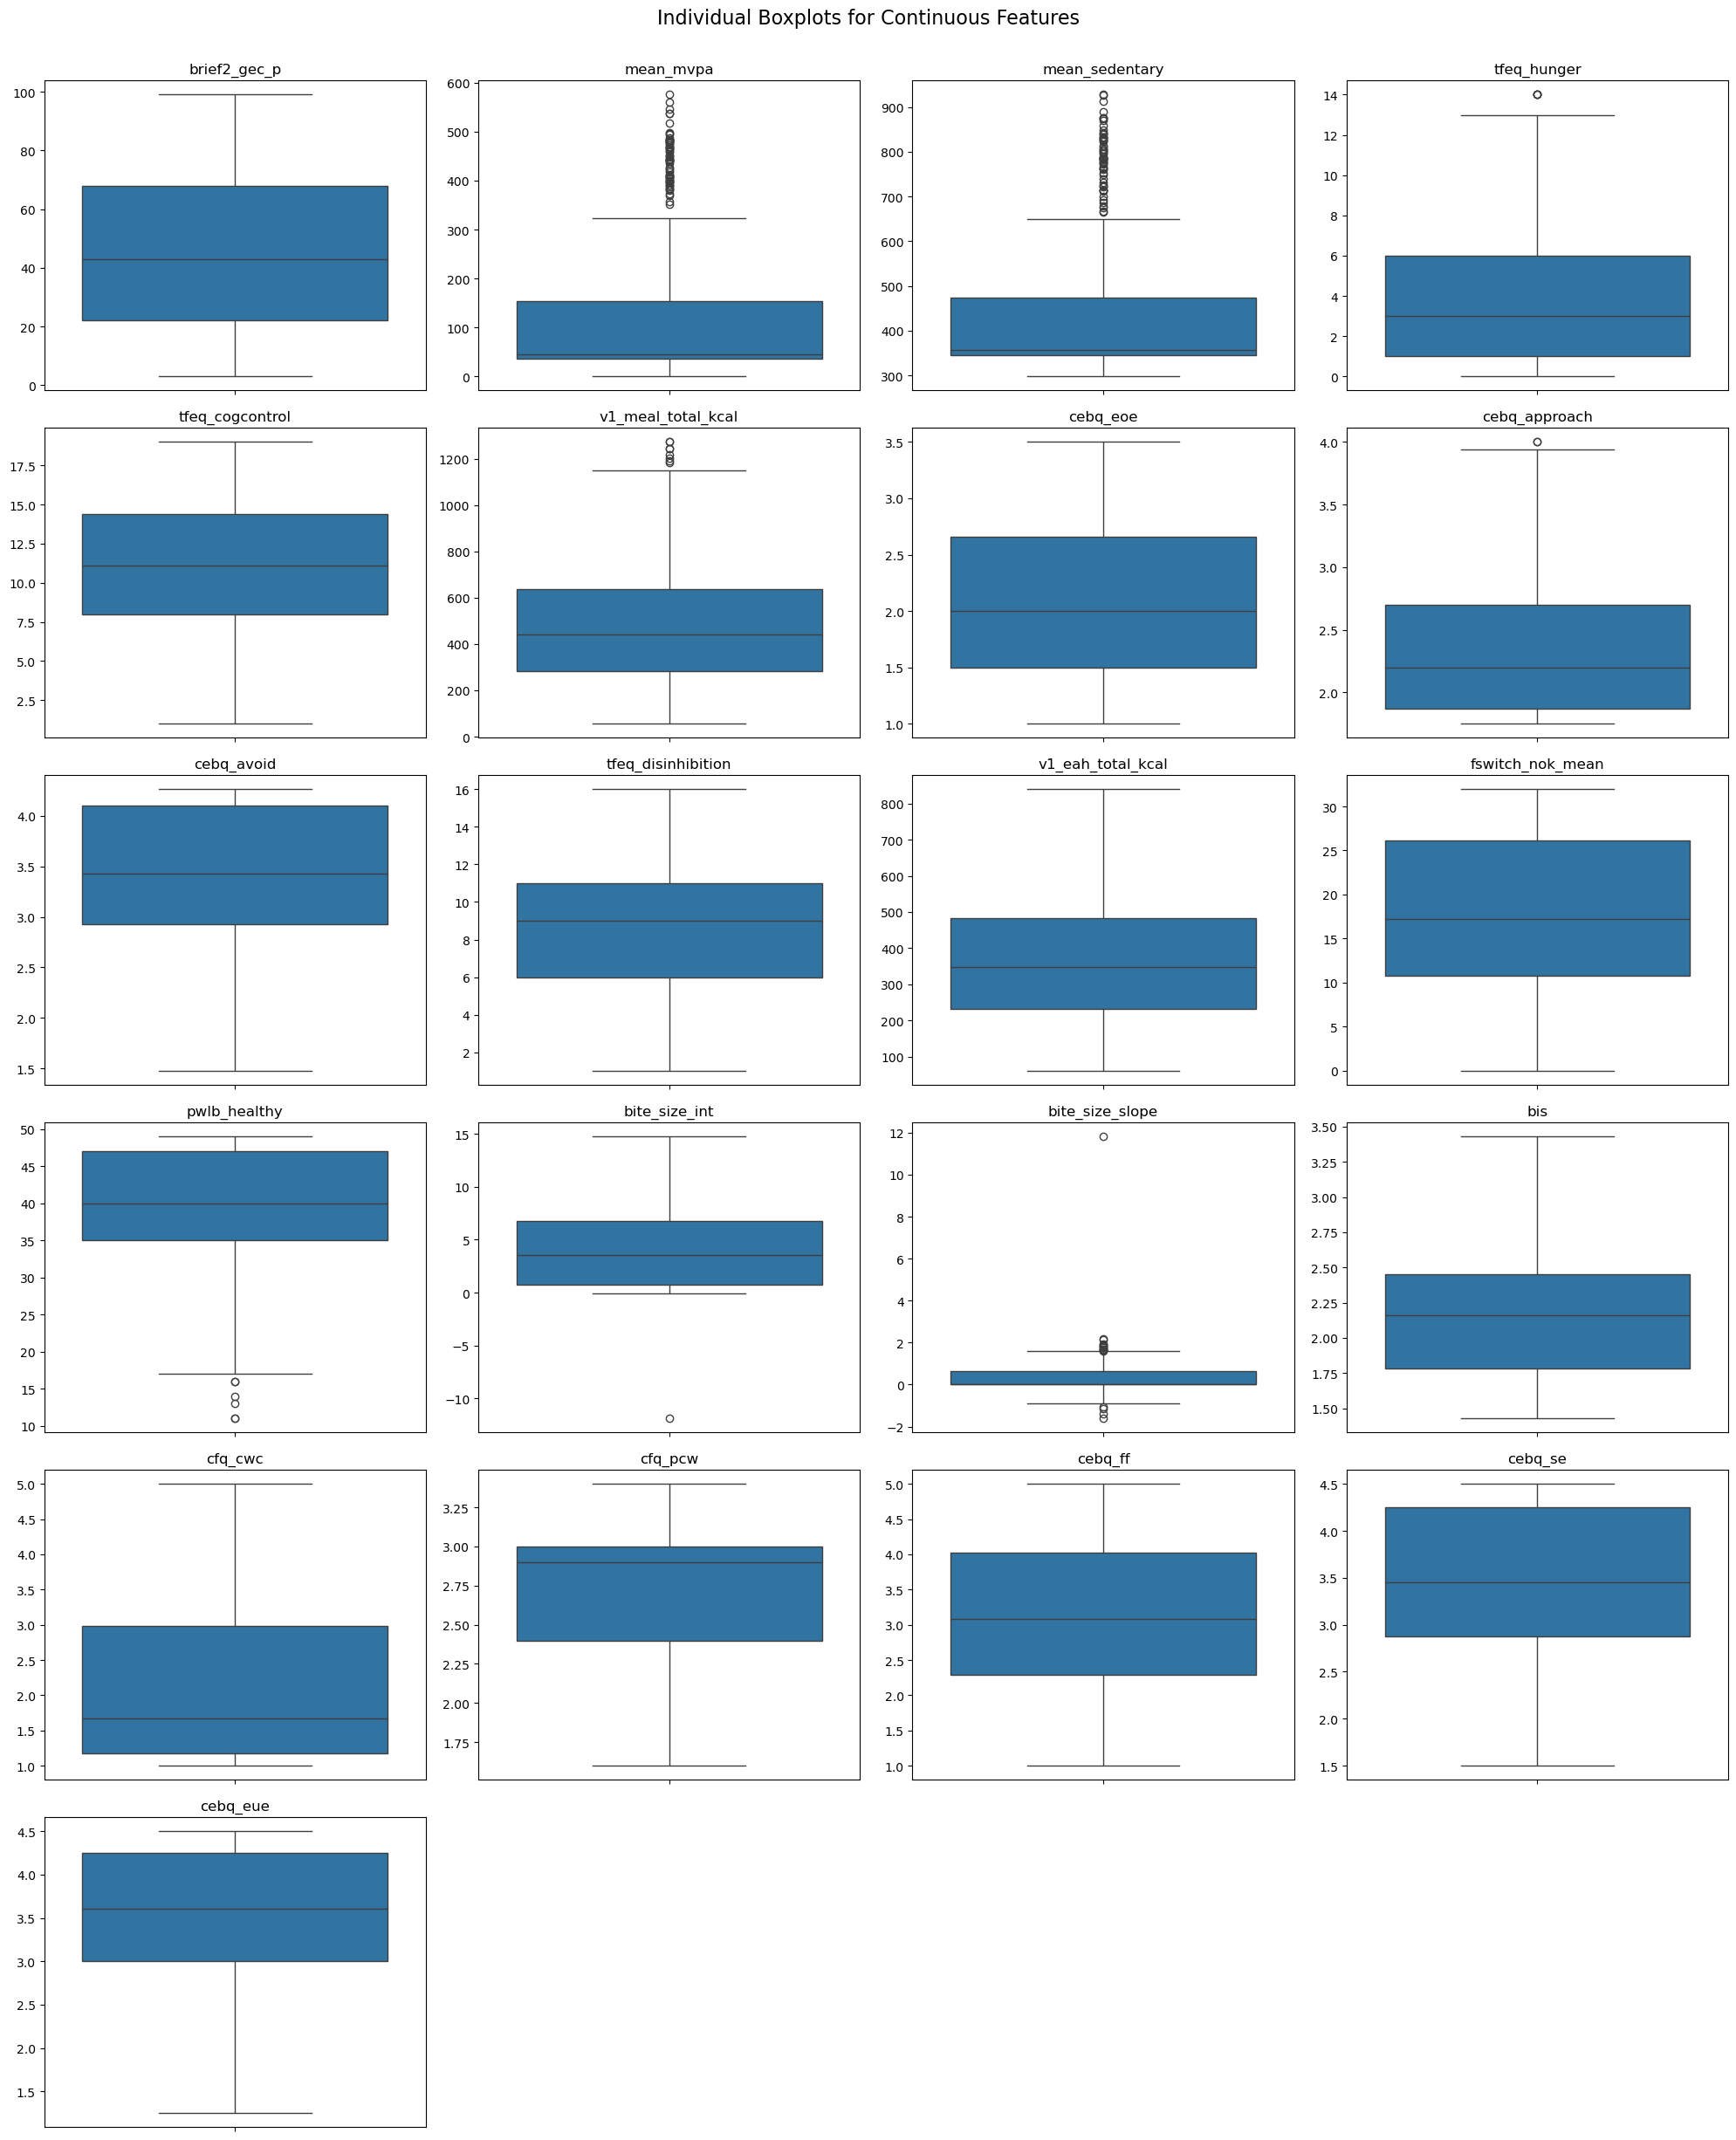

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# --- List of continuous variables ---
continuous_cols = [
    'brief2_gec_p', 'mean_mvpa', 'mean_sedentary',
    'tfeq_hunger', 'tfeq_cogcontrol', 'v1_meal_total_kcal',
    'cebq_eoe', 'cebq_approach', 'cebq_avoid', 'tfeq_disinhibition',
    'v1_eah_total_kcal', 'fswitch_nok_mean', 'pwlb_healthy',
    'bite_size_int', 'bite_size_slope', 'bis',
    'cfq_cwc', 'cfq_pcw', 'cebq_ff', 'cebq_se', 'cebq_eue'
]

# --- Plot configuration ---
n_cols = 4
n_rows = math.ceil(len(continuous_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4 * n_rows))

for idx, col in enumerate(continuous_cols):
    row = idx // n_cols
    col_idx = idx % n_cols
    ax = axes[row, col_idx] if n_rows > 1 else axes[col_idx]

    sns.boxplot(data=df, y=col, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Hide any unused subplots
for idx in range(len(continuous_cols), n_rows * n_cols):
    fig.delaxes(axes.flatten()[idx])

plt.tight_layout()
plt.suptitle("Individual Boxplots for Continuous Features", y=1.02, fontsize=16)
plt.show()


## Winsorizing outliers

In [29]:
import pandas as pd

# --- Load the imputed dataset ---
df = pd.read_csv("imputed_dataset.csv")

# --- Winsorization function ---
def winsorize_series(series, lower=0.01, upper=0.99):
    return series.clip(lower=series.quantile(lower), upper=series.quantile(upper))

# --- List of continuous variables to winsorize ---
continuous_cols = [
    'mean_mvpa', 'mean_sedentary','cebq_eoe', 'cebq_approach', 'v1_eah_total_kcal', 'bite_size_int','bite_size_slope', 'cfq_cwc', 'cfq_pcw'
]

# --- Apply winsorization to all specified continuous variables ---
for col in continuous_cols:
    if col in df.columns:
        df[col] = winsorize_series(df[col], lower=0.01, upper=0.99)

# --- Save the winsorized dataset ---
df.to_csv("winsorized_dataset.csv", index=False)


# 5. Data Splitting (80:20 - Train: Test) stratified by sex
Saved train and test set separately

In [35]:
from sklearn.model_selection import train_test_split
import pandas as pd


# --- Load winsorized dataset ---
df = pd.read_csv("winsorized_dataset.csv")

# --- Stratified split based on 'sex' ---
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['sex'],
    random_state=42  # for reproducibility
)

# --- Save splits if needed ---
train_df.to_csv("train_split_stratified.csv", index=False)
test_df.to_csv("test_split_stratified.csv", index=False)

# --- Optional: Check class balance ---
print("Sex distribution in full data:\n", df['sex'].value_counts(normalize=True))
print("Sex distribution in train:\n", train_df['sex'].value_counts(normalize=True))
print("Sex distribution in test:\n", test_df['sex'].value_counts(normalize=True))

Sex distribution in full data:
 sex
0    0.520349
1    0.479651
Name: proportion, dtype: float64
Sex distribution in train:
 sex
0    0.52
1    0.48
Name: proportion, dtype: float64
Sex distribution in test:
 sex
0    0.521739
1    0.478261
Name: proportion, dtype: float64


## 6. Feature Transformation
One-hot-encoding for nominal categorical data
Ordinal data can be left as is

In [36]:
import pandas as pd

# Load the dataset
df = pd.read_csv("train_split_stratified.csv")

# One-hot encode 'sex' and drop original column
df = pd.get_dummies(df, columns=['sex'], drop_first=True)

# Save updated dataset back to same file
df.to_csv("train_split_stratified.csv", index=False)

# 7. Feature Selection

#### A. Feature Analysis: Which features or predictors have low variability?

In [37]:
## Data Variability
import pandas as pd

# Load train split
df_train = pd.read_csv("train_split_stratified.csv")

# Drop ID if present
df_train = df_train.drop(columns=['id'], errors='ignore')

# Threshold: below this std or unique % is considered low variability
low_std_thresh = 0.01
low_unique_thresh = 0.01  # 1% of sample size

n_rows = df_train.shape[0]
low_variability = []

for col in df_train.select_dtypes(include=['float64', 'int64']).columns:
    std = df_train[col].std()
    unique_vals = df_train[col].nunique()
    unique_pct = unique_vals / n_rows
    if std < low_std_thresh or unique_pct < low_unique_thresh:
        low_variability.append((col, round(std, 4), unique_vals, round(unique_pct, 4)))

# Show results
low_var_df = pd.DataFrame(low_variability, columns=['Feature', 'Std Dev', 'Unique Values', 'Unique %'])
print("⚠️ Low Variability Features:")
print(low_var_df)

⚠️ Low Variability Features:
           Feature  Std Dev  Unique Values  Unique %
0  risk_status_mom   0.4884              2    0.0073


#### Visualizing correlation to outcome (v7_bmi_percentile: Follow-up BMI percentile)

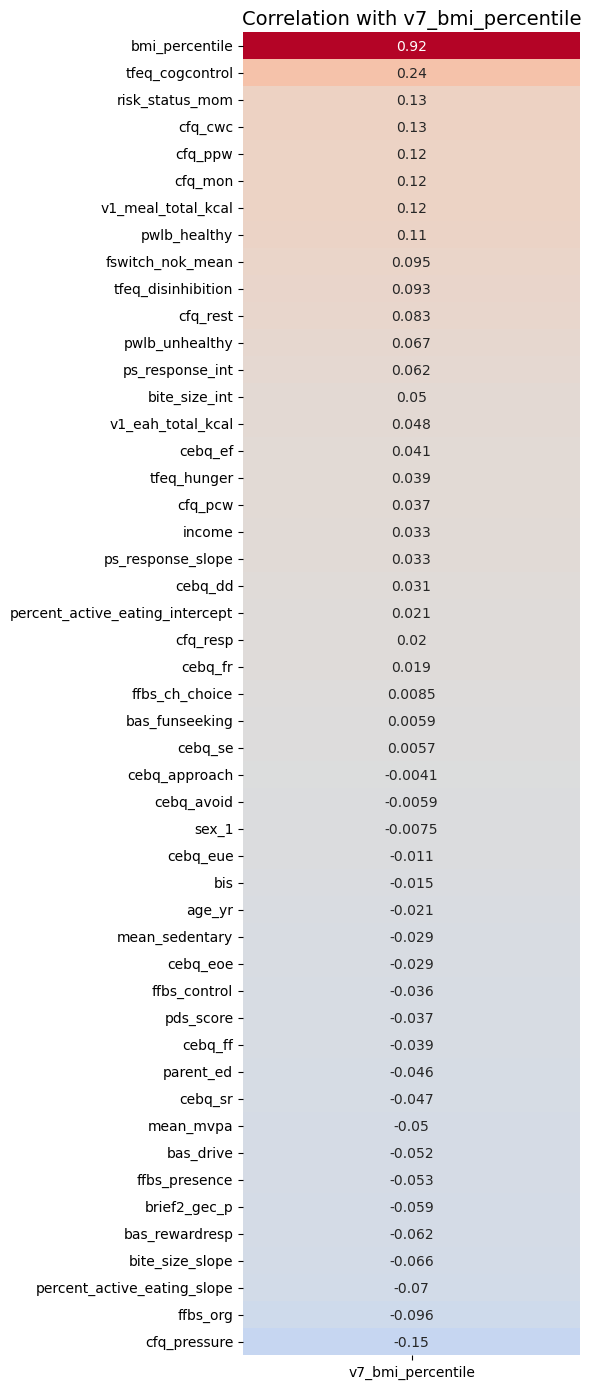

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load dataset ---
df = pd.read_csv("train_split_stratified.csv")

# --- List of selected features for modeling ---
selected_features = [
    'risk_status_mom', 'age_yr', 'income', 'parent_ed', 
    'bmi_percentile','mean_mvpa','mean_sedentary', 
    'percent_active_eating_slope' , 'percent_active_eating_intercept', 
    'bite_size_slope', 'bite_size_int',	'fswitch_nok_mean',	
    'ps_response_slope','ps_response_int',	
    'pds_score', 'v1_meal_total_kcal', 'v1_eah_total_kcal', 'cebq_fr', 'cebq_eoe', 
    'cebq_ef', 'cebq_dd', 'cebq_sr', 'cebq_se',	'cebq_eue', 'cebq_ff', 'cebq_approach',	'cebq_avoid','cfq_resp',
    'cfq_pcw','cfq_ppw', 'cfq_cwc',	'cfq_rest', 'cfq_pressure', 'cfq_mon', 'ffbs_control',
    'ffbs_presence','ffbs_ch_choice','ffbs_org','pwlb_healthy',	'pwlb_unhealthy','tfeq_cogcontrol', 
    'tfeq_disinhibition', 'tfeq_hunger', 'bis',	'bas_funseeking', 'bas_drive', 'bas_rewardresp',	'brief2_gec_p',	'sex'
]

# --- Compute correlations with v7_bmi_percentile ---
target = 'v7_bmi_percentile'
correlations = df[selected_features + [target]].corr()[target].drop(target).sort_values(ascending=False)

# --- Plot as vertical heatmap ---
plt.figure(figsize=(6, 14))
sns.heatmap(correlations.to_frame(), annot=True, cmap="coolwarm", center=0, cbar=False)
plt.title("Correlation with v7_bmi_percentile", fontsize=14)
plt.tight_layout()
plt.show()

Baseline BMI percentile explains a lot of follow-up BMI percentile. Since the idea is predicting future obesity accurately, adding baseline BMI percentile will help. However, this masks the influence of other behavioral factors. Therefore, we can do RFE next without baseline BMI percentile to help understand the important features without getting masked by basline BMI%. We will train 2 models - one with baseline BMI%, one without. One with baseline BMI% can help with model accuracy; one without helps understand the patterns of behavior beyond baseline BMI%. 

#### Nested Cross-Validation (outer loop: cross validation for hyperparameters; inner loop: RFE-CV) - with BMI%


🔁 Outer Fold 1
✅ Best MAE: 3.09
📊 Best Hyperparams: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
🔢 Features Selected (3): ['bmi_percentile', 'mean_mvpa', 'bas_drive']

🔁 Outer Fold 2
✅ Best MAE: 4.03
📊 Best Hyperparams: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
🔢 Features Selected (3): ['bmi_percentile', 'mean_mvpa', 'mean_sedentary']

🔁 Outer Fold 3
✅ Best MAE: 4.03
📊 Best Hyperparams: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
🔢 Features Selected (4): ['bmi_percentile', 'mean_mvpa', 'mean_sedentary', 'v1_meal_total_kcal']


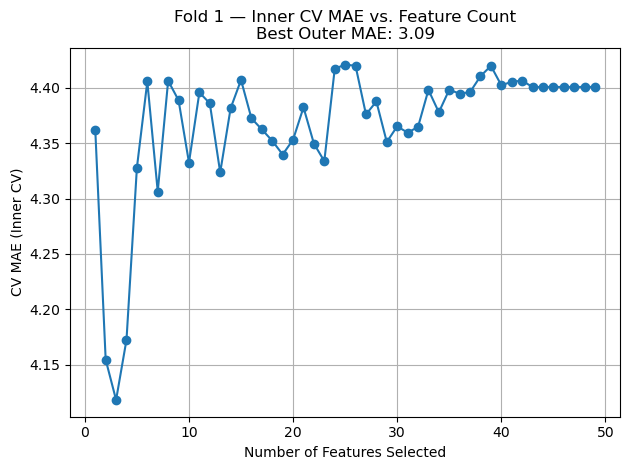

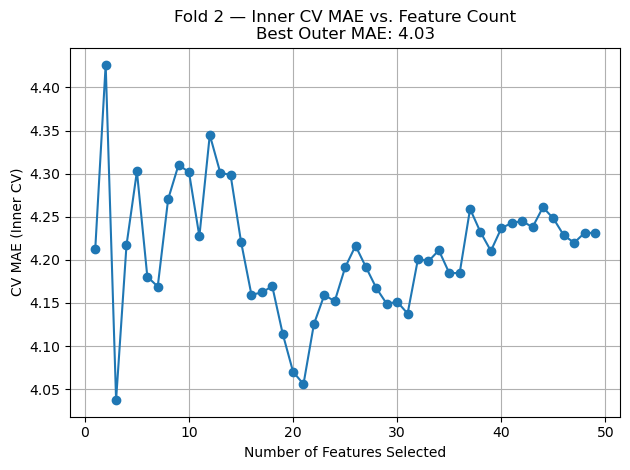

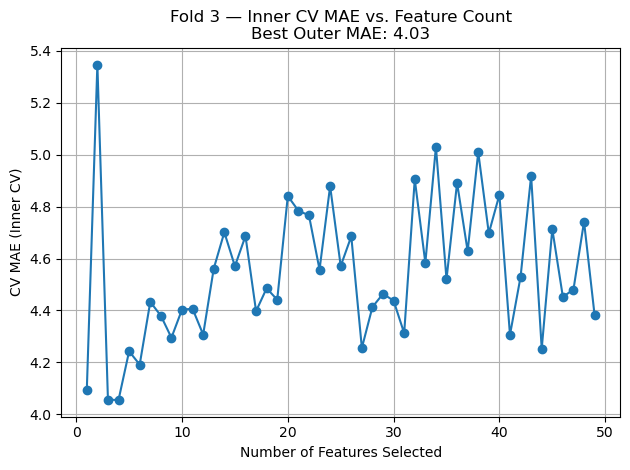


🏆 === BEST COMBINATION ACROSS ALL FOLDS ===
Best found in outer fold: 1
Lowest MAE: 3.09

🔧 Best Hyperparameter Configuration:
  colsample_bytree: 1.0
  learning_rate: 0.1
  max_depth: 3
  n_estimators: 50
  subsample: 0.8

📌 Features Selected (Total: 3):
  - bmi_percentile
  - mean_mvpa
  - bas_drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("train_split_stratified.csv")

# Define features and target
feature_cols = [
    'risk_status_mom', 'age_yr', 'income', 'parent_ed',
    'bmi_percentile', 'mean_mvpa', 'mean_sedentary',
    'percent_active_eating_slope', 'percent_active_eating_intercept',
    'bite_size_slope', 'bite_size_int', 'fswitch_nok_mean',
    'ps_response_slope', 'ps_response_int',
    'pds_score', 'v1_meal_total_kcal', 'v1_eah_total_kcal',
    'cebq_fr', 'cebq_eoe', 'cebq_ef', 'cebq_dd', 'cebq_sr', 'cebq_se',
    'cebq_eue', 'cebq_ff', 'cebq_approach', 'cebq_avoid', 'cfq_resp',
    'cfq_pcw', 'cfq_ppw', 'cfq_cwc', 'cfq_rest', 'cfq_pressure', 'cfq_mon',
    'ffbs_control', 'ffbs_presence', 'ffbs_ch_choice', 'ffbs_org',
    'pwlb_healthy', 'pwlb_unhealthy', 'tfeq_cogcontrol',
    'tfeq_disinhibition', 'tfeq_hunger', 'bis', 'bas_funseeking',
    'bas_drive', 'bas_rewardresp', 'brief2_gec_p', 'sex_1'
]
target = 'v7_bmi_percentile'
feature_names = np.array(feature_cols)

X = df[feature_cols].values
y = df[target].values

# 3-fold outer CV for honest model performance estimation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50,100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

results_by_fold = []

# Outer loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"\n🔁 Outer Fold {fold}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fold_results = []

    # Grid search over hyperparameters
    for params in ParameterGrid(param_grid):
        model = XGBRegressor(objective='reg:squarederror', random_state=42, **params)

        # RFECV with 3-fold inner CV
        rfecv = RFECV(
            estimator=model,
            step=1,
            cv=3,
            scoring='neg_mean_absolute_error',
            n_jobs=-1
        )
        rfecv.fit(X_train, y_train)

        selected_mask = rfecv.support_
        selected_features = feature_names[selected_mask]

        # Re-train model on selected features
        model.fit(rfecv.transform(X_train), y_train)
        preds = model.predict(rfecv.transform(X_test))
        mae = mean_absolute_error(y_test, preds)

        fold_results.append({
            "params": params,
            "mae": mae,
            "n_features": selected_mask.sum(),
            "features": selected_features,
            "cv_mae_by_features": -rfecv.cv_results_['mean_test_score']
          # Flip to positive MAE
        })

    # Pick best inner model for this outer fold
    best = sorted(fold_results, key=lambda x: x['mae'])[0]
    results_by_fold.append(best)

    print(f"✅ Best MAE: {best['mae']:.2f}")
    print(f"📊 Best Hyperparams: {best['params']}")
    print(f"🔢 Features Selected ({best['n_features']}): {list(best['features'])}")

# Plot CV MAE vs. number of features
for i, res in enumerate(results_by_fold):
    plt.figure()
    plt.plot(range(1, len(res["cv_mae_by_features"]) + 1), res["cv_mae_by_features"], marker='o')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("CV MAE (Inner CV)")
    plt.title(f"Fold {i+1} — Inner CV MAE vs. Feature Count\nBest Outer MAE: {res['mae']:.2f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Best model across all folds
all_maes = [r['mae'] for r in results_by_fold]
best_fold_idx = int(np.argmin(all_maes))
best_overall = results_by_fold[best_fold_idx]

print("\n🏆 === BEST COMBINATION ACROSS ALL FOLDS ===")
print(f"Best found in outer fold: {best_fold_idx + 1}")
print(f"Lowest MAE: {best_overall['mae']:.2f}")

print("\n🔧 Best Hyperparameter Configuration:")
for key, val in best_overall['params'].items():
    print(f"  {key}: {val}")

print("\n📌 Features Selected (Total: {}):".format(best_overall['n_features']))
for feat in best_overall['features']:
    print(f"  - {feat}")

#### Nested Cross-Validation (outer loop: cross validation for hyperparameters; inner loop: RFE-CV) (without BMI%)


🔁 Outer Fold 1
✅ Best MAE: 8.68
📊 Best Hyperparams: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
🔢 Features Selected (12): ['mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope', 'v1_meal_total_kcal', 'cebq_dd', 'cebq_ff', 'cebq_approach', 'cfq_ppw', 'cfq_cwc', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_hunger']

🔁 Outer Fold 2
✅ Best MAE: 12.62
📊 Best Hyperparams: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}
🔢 Features Selected (20): ['mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope', 'bite_size_slope', 'bite_size_int', 'fswitch_nok_mean', 'ps_response_int', 'v1_meal_total_kcal', 'cebq_ef', 'cebq_dd', 'cfq_pcw', 'cfq_ppw', 'cfq_cwc', 'cfq_rest', 'cfq_pressure', 'cfq_mon', 'ffbs_org', 'pwlb_healthy', 'tfeq_cogcontrol', 'bas_rewardresp']

🔁 Outer Fold 3
✅ Best MAE: 12.51
📊 Best Hyperparams: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, '

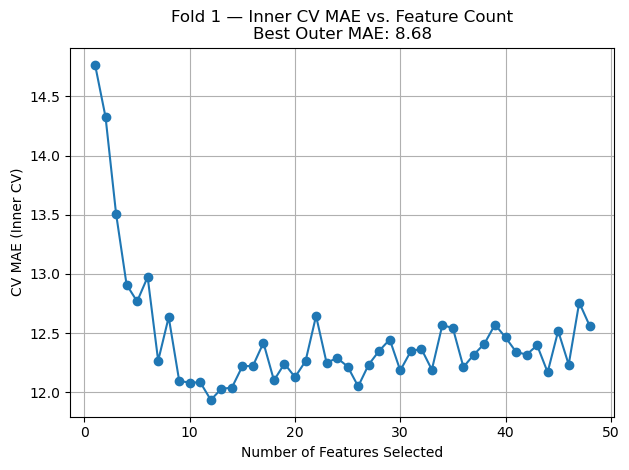

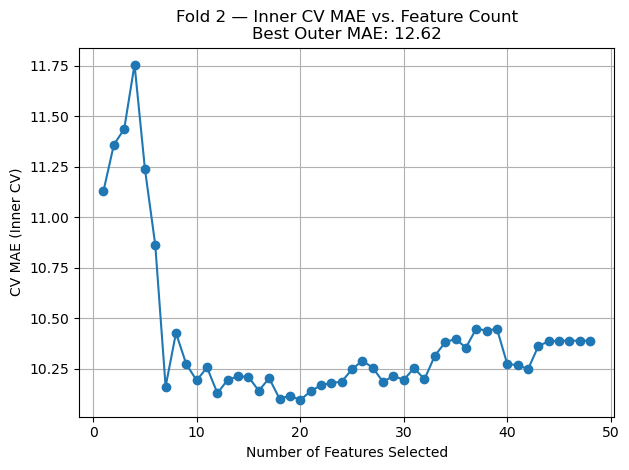

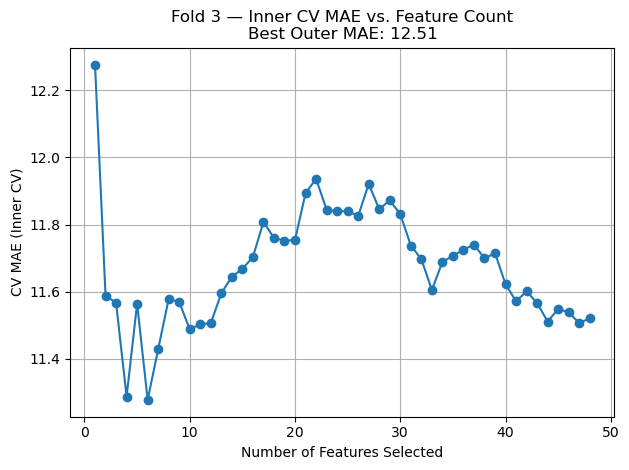


🏆 === BEST COMBINATION ACROSS ALL FOLDS ===
Best found in outer fold: 1
Lowest MAE: 8.68

🔧 Best Hyperparameter Configuration:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 3
  n_estimators: 50
  subsample: 0.8

📌 Features Selected (Total: 12):
  - mean_mvpa
  - mean_sedentary
  - percent_active_eating_slope
  - v1_meal_total_kcal
  - cebq_dd
  - cebq_ff
  - cebq_approach
  - cfq_ppw
  - cfq_cwc
  - pwlb_healthy
  - tfeq_cogcontrol
  - tfeq_hunger


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Load dataset
df = pd.read_csv("train_split_stratified.csv")

# Define features and target
feature_cols = [
    'risk_status_mom', 'age_yr', 'income', 'parent_ed',
    'mean_mvpa', 'mean_sedentary',
    'percent_active_eating_slope', 'percent_active_eating_intercept',
    'bite_size_slope', 'bite_size_int', 'fswitch_nok_mean',
    'ps_response_slope', 'ps_response_int',
    'pds_score', 'v1_meal_total_kcal', 'v1_eah_total_kcal',
    'cebq_fr', 'cebq_eoe', 'cebq_ef', 'cebq_dd', 'cebq_sr', 'cebq_se',
    'cebq_eue', 'cebq_ff', 'cebq_approach', 'cebq_avoid', 'cfq_resp',
    'cfq_pcw', 'cfq_ppw', 'cfq_cwc', 'cfq_rest', 'cfq_pressure', 'cfq_mon',
    'ffbs_control', 'ffbs_presence', 'ffbs_ch_choice', 'ffbs_org',
    'pwlb_healthy', 'pwlb_unhealthy', 'tfeq_cogcontrol',
    'tfeq_disinhibition', 'tfeq_hunger', 'bis', 'bas_funseeking',
    'bas_drive', 'bas_rewardresp', 'brief2_gec_p', 'sex_1'
]
target = 'v7_bmi_percentile'
feature_names = np.array(feature_cols)

X = df[feature_cols].values
y = df[target].values

# 3-fold outer CV for honest model performance estimation
outer_cv = KFold(n_splits=3, shuffle=True, random_state=42)

# Hyperparameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [50,100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8, 1.0]
}

results_by_fold = []

# Outer loop
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
    print(f"\n🔁 Outer Fold {fold}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    fold_results = []

    # Grid search over hyperparameters
    for params in ParameterGrid(param_grid):
        model = XGBRegressor(objective='reg:squarederror', random_state=42, **params)

        # RFECV with 3-fold inner CV
        rfecv = RFECV(
            estimator=model,
            step=1,
            cv=3,
            scoring='neg_mean_absolute_error',
            n_jobs=-1
        )
        rfecv.fit(X_train, y_train)

        selected_mask = rfecv.support_
        selected_features = feature_names[selected_mask]

        # Re-train model on selected features
        model.fit(rfecv.transform(X_train), y_train)
        preds = model.predict(rfecv.transform(X_test))
        mae = mean_absolute_error(y_test, preds)

        fold_results.append({
            "params": params,
            "mae": mae,
            "n_features": selected_mask.sum(),
            "features": selected_features,
            "cv_mae_by_features": -rfecv.cv_results_['mean_test_score']
          # Flip to positive MAE
        })

    # Pick best inner model for this outer fold
    best = sorted(fold_results, key=lambda x: x['mae'])[0]
    results_by_fold.append(best)

    print(f"✅ Best MAE: {best['mae']:.2f}")
    print(f"📊 Best Hyperparams: {best['params']}")
    print(f"🔢 Features Selected ({best['n_features']}): {list(best['features'])}")

# Plot CV MAE vs. number of features
for i, res in enumerate(results_by_fold):
    plt.figure()
    plt.plot(range(1, len(res["cv_mae_by_features"]) + 1), res["cv_mae_by_features"], marker='o')
    plt.xlabel("Number of Features Selected")
    plt.ylabel("CV MAE (Inner CV)")
    plt.title(f"Fold {i+1} — Inner CV MAE vs. Feature Count\nBest Outer MAE: {res['mae']:.2f}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Best model across all folds
all_maes = [r['mae'] for r in results_by_fold]
best_fold_idx = int(np.argmin(all_maes))
best_overall = results_by_fold[best_fold_idx]

print("\n🏆 === BEST COMBINATION ACROSS ALL FOLDS ===")
print(f"Best found in outer fold: {best_fold_idx + 1}")
print(f"Lowest MAE: {best_overall['mae']:.2f}")

print("\n🔧 Best Hyperparameter Configuration:")
for key, val in best_overall['params'].items():
    print(f"  {key}: {val}")

print("\n📌 Features Selected (Total: {}):".format(best_overall['n_features']))
for feat in best_overall['features']:
    print(f"  - {feat}")

#### Model Training with BMI% and without BMI% - separately (based on above selected features)

In [56]:
import pandas as pd
from xgboost import XGBRegressor
import joblib

# --- Load data ---
df = pd.read_csv("train_split_stratified.csv")
target = 'v7_bmi_percentile'
y = df[target]

# ===============================
# ✅ Model 1: Behavioral model (without BMI percentile)
# ===============================
features_behavioral = [
    'mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope',
    'v1_meal_total_kcal', 'cebq_dd', 'cebq_ff', 'cebq_approach',
    'cfq_ppw', 'cfq_cwc', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_hunger'
]
X_behavior = df[features_behavioral]

# Define and train model
model_behavior = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=50,
    subsample=0.8,
    random_state=42
)
model_behavior.fit(X_behavior, y)
print("✅ Trained behavioral model (without BMI%)")

# Save model
joblib.dump(model_behavior, "xgb_behavior_model_without_bmi.pkl")
print("💾 Saved: xgb_behavior_model_without_bmi.pkl")

# ===============================
# ✅ Model 2: BMI-based model (3 features only)
# ===============================
features_with_bmi = ['bmi_percentile', 'mean_mvpa', 'bas_drive']
X_bmi = df[features_with_bmi]

# Define and train model
model_bmi = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    subsample=0.8,
    random_state=42
)
model_bmi.fit(X_bmi, y)
print("✅ Trained BMI-based model")

# Save model
joblib.dump(model_bmi, "xgb_model_with_bmi.pkl")
print("💾 Saved: xgb_model_with_bmi.pkl")


✅ Trained behavioral model (without BMI%)
💾 Saved: xgb_behavior_model_without_bmi.pkl
✅ Trained BMI-based model
💾 Saved: xgb_model_with_bmi.pkl


#### Model Evaluation of separate models: with BMI% and without BMI% - separately

In [69]:
import pandas as pd
import joblib
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load test data ---
test_df = pd.read_csv("test_split_stratified.csv")

# --- One-hot encode 'sex' to binary 'sex_1' ---
test_df['sex_1'] = test_df['sex'].map({'Male': 0, 'Female': 1})

# --- Define target and features ---
target = 'v7_bmi_percentile'
y_test = test_df[target]

features_behavioral = [
    'mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope',
    'v1_meal_total_kcal', 'cebq_dd', 'cebq_ff', 'cebq_approach',
    'cfq_ppw', 'cfq_cwc', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_hunger'
]

features_with_bmi = ['bmi_percentile', 'mean_mvpa', 'bas_drive']

# --- Load models ---
model_behavior = joblib.load("xgb_behavior_model_without_bmi.pkl")
model_bmi = joblib.load("xgb_model_with_bmi.pkl")

# --- Prepare inputs ---
X_test_behavior = test_df[features_behavioral]
X_test_bmi = test_df[features_with_bmi]

# --- Evaluation function ---
def evaluate_model(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 Evaluation: {label}")
    print(f"  MAE : {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²  : {r2:.2f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# --- Run evaluations ---

# Behavioral model (without BMI)
y_pred_behavior = model_behavior.predict(X_test_behavior)
metrics_behavior = evaluate_model(y_test, y_pred_behavior, "Behavioral Model (No BMI%)")

# BMI-based model
y_pred_bmi = model_bmi.predict(X_test_bmi)
metrics_bmi = evaluate_model(y_test, y_pred_bmi, "BMI-Based Model")

# Optional: print both result dicts
print("\n✅ Summary:")
print("Behavioral Model Metrics:", metrics_behavior)
print("BMI-Based Model Metrics:", metrics_bmi)



📊 Evaluation: Behavioral Model (No BMI%)
  MAE : 8.16
  RMSE: 11.68
  R²  : 0.20

📊 Evaluation: BMI-Based Model
  MAE : 2.82
  RMSE: 4.65
  R²  : 0.87

✅ Summary:
Behavioral Model Metrics: {'MAE': 8.158772244660751, 'RMSE': 11.67801936379436, 'R2': 0.19641905565343853}
BMI-Based Model Metrics: {'MAE': 2.8247185438957767, 'RMSE': 4.647772461732412, 'R2': 0.8727139046140108}


#### SHAP for the models : with BMI and without BMI%

📊 SHAP Summary Plot: Behavioral Model (No BMI%)


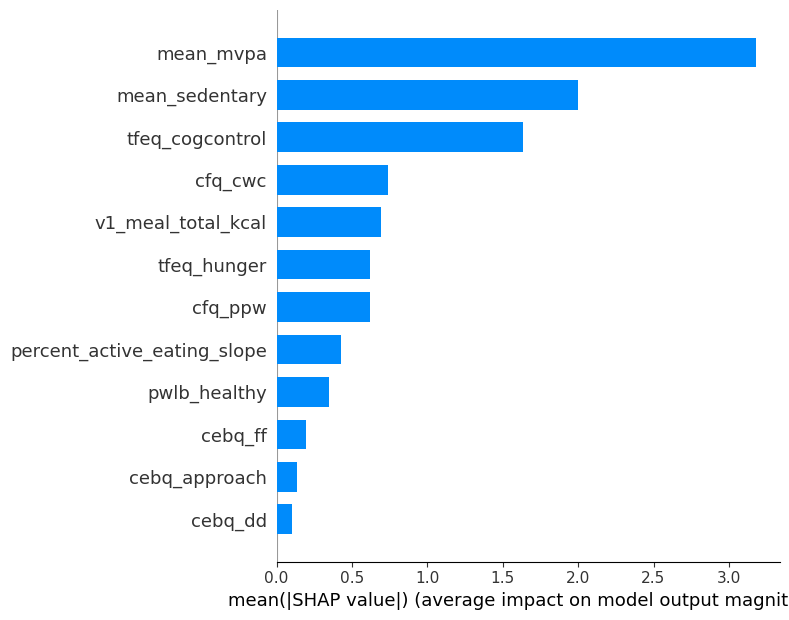

📊 SHAP Summary Plot: BMI-Based Model


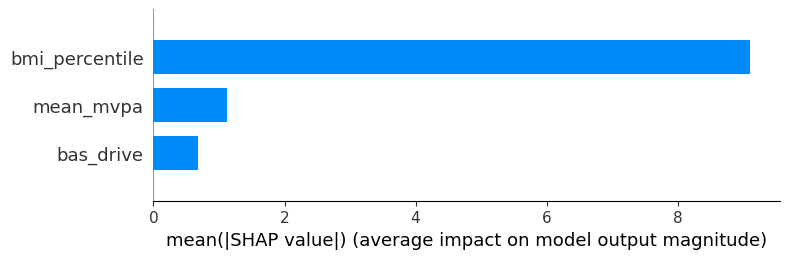

📊 SHAP Beeswarm Plot: Behavioral Model (No BMI%)


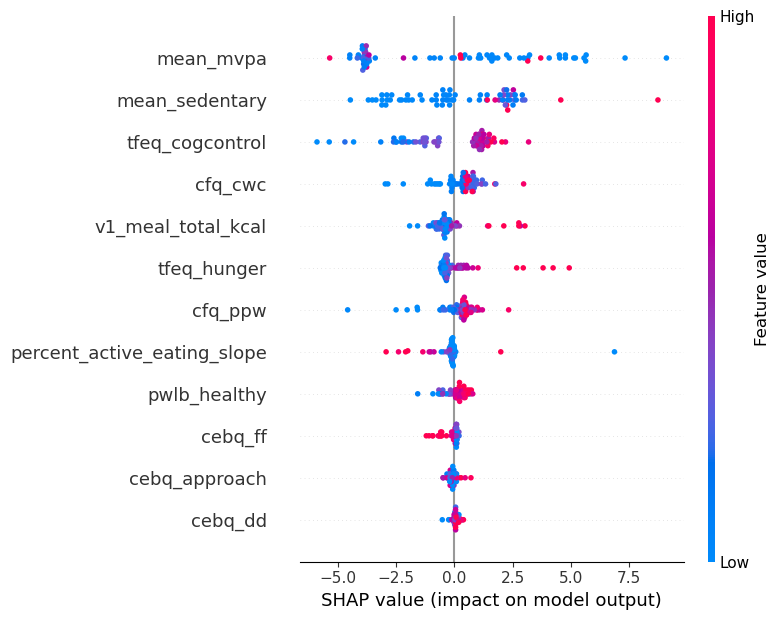

📊 SHAP Beeswarm Plot: BMI-Based Model


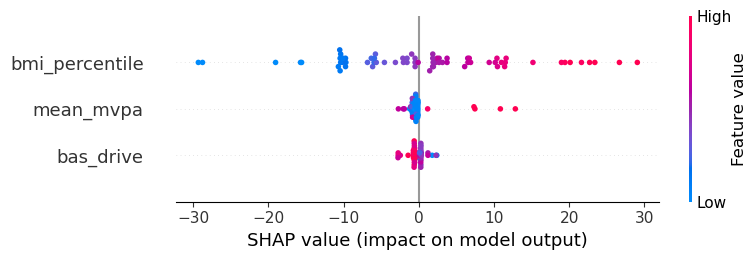

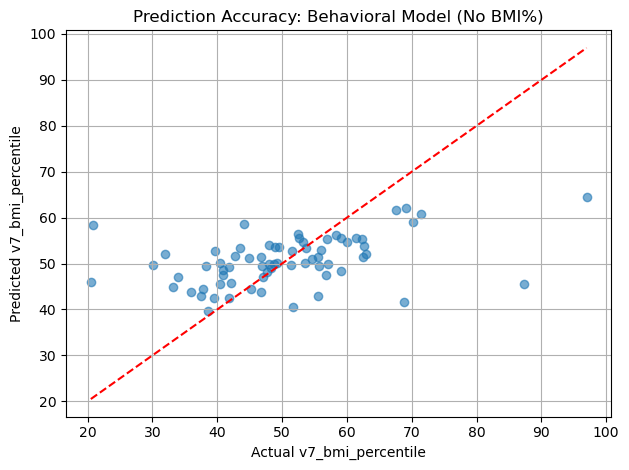

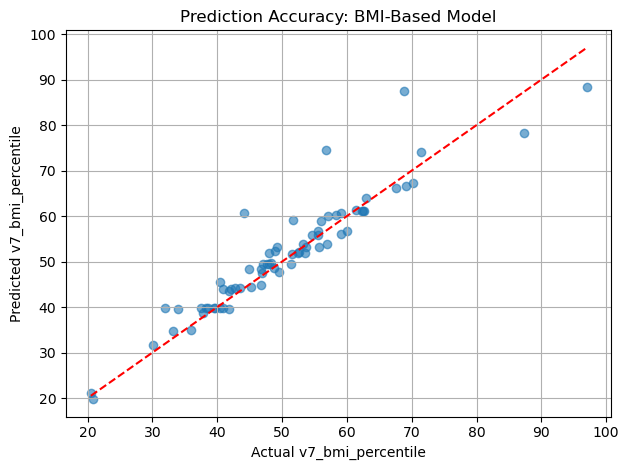

In [70]:
import shap
import matplotlib.pyplot as plt

# --- TreeExplainer avoids torch dependencies ---
explainer_behavior = shap.TreeExplainer(model_behavior)
shap_values_behavior = explainer_behavior.shap_values(X_test_behavior)

explainer_bmi = shap.TreeExplainer(model_bmi)
shap_values_bmi = explainer_bmi.shap_values(X_test_bmi)

# --- SHAP summary bar plots ---
print("📊 SHAP Summary Plot: Behavioral Model (No BMI%)")
shap.summary_plot(shap_values_behavior, X_test_behavior, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

print("📊 SHAP Summary Plot: BMI-Based Model")
shap.summary_plot(shap_values_bmi, X_test_bmi, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

# --- SHAP beeswarm plots ---
print("📊 SHAP Beeswarm Plot: Behavioral Model (No BMI%)")
shap.summary_plot(shap_values_behavior, X_test_behavior, show=False)
plt.tight_layout()
plt.show()

print("📊 SHAP Beeswarm Plot: BMI-Based Model")
shap.summary_plot(shap_values_bmi, X_test_bmi, show=False)
plt.tight_layout()
plt.show()

# --- Scatter plot: Prediction Accuracy (Actual vs Predicted) ---
plt.figure()
plt.scatter(y_test, y_pred_behavior, alpha=0.6)
plt.xlabel("Actual v7_bmi_percentile")
plt.ylabel("Predicted v7_bmi_percentile")
plt.title("Prediction Accuracy: Behavioral Model (No BMI%)")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(y_test, y_pred_bmi, alpha=0.6)
plt.xlabel("Actual v7_bmi_percentile")
plt.ylabel("Predicted v7_bmi_percentile")
plt.title("Prediction Accuracy: BMI-Based Model")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Model Training: Combining Features (model with BMI% vs model without BMI%)

In [71]:
import pandas as pd
import joblib
from xgboost import XGBRegressor

# --- Load training data ---
df = pd.read_csv("train_split_stratified.csv")

# --- Define feature set and target ---
features_combined = [
    'bmi_percentile', 'mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope',
    'v1_meal_total_kcal', 'cebq_dd', 'cebq_ff', 'cebq_approach',
    'cfq_ppw', 'cfq_cwc', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_hunger'
]
target = 'v7_bmi_percentile'

X = df[features_combined]
y = df[target]

# --- Define and train model ---
model_combined = XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=1.0,
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    subsample=0.8,
    random_state=42
)

model_combined.fit(X, y)
print("✅ Trained BMI-Combined Model")

# --- Save model ---
joblib.dump(model_combined, "xgb_model_bmi_combined.pkl")
print("💾 Saved: xgb_model_bmi_combined.pkl")

✅ Trained BMI-Combined Model
💾 Saved: xgb_model_bmi_combined.pkl



📊 Evaluation: BMI-Combined Model
  MAE : 2.65
  RMSE: 4.09
  R²  : 0.90


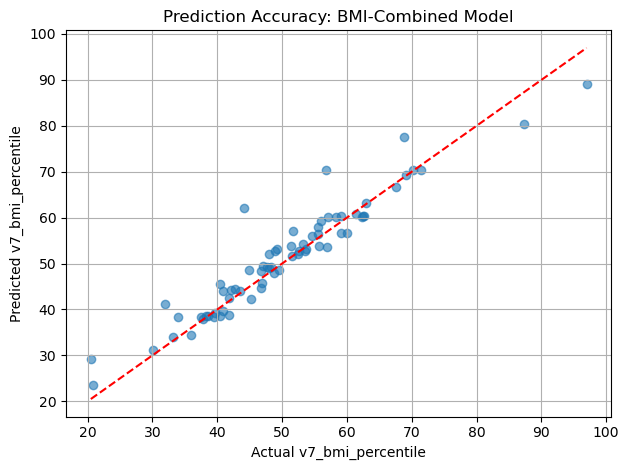

In [73]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load test data ---
test_df = pd.read_csv("test_split_stratified.csv")
test_df["sex_1"] = test_df["sex"].map({"Male": 0, "Female": 1})

# --- Define features and target ---
features_combined = [
    'bmi_percentile', 'mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope',
    'v1_meal_total_kcal', 'cebq_dd', 'cebq_ff', 'cebq_approach',
    'cfq_ppw', 'cfq_cwc', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_hunger'
]
target = "v7_bmi_percentile"
X_combined = test_df[features_combined]
y = test_df[target]

# --- Load trained model ---
model = joblib.load("xgb_model_bmi_combined.pkl")

# --- Predict and evaluate ---
y_pred = model.predict(X_combined)

mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print("\n📊 Evaluation: BMI-Combined Model")
print(f"  MAE : {mae:.2f}")
print(f"  RMSE: {rmse:.2f}")
print(f"  R²  : {r2:.2f}")

# --- Scatter plot: Actual vs. Predicted ---
plt.figure()
plt.scatter(y, y_pred, alpha=0.6)
plt.xlabel("Actual v7_bmi_percentile")
plt.ylabel("Predicted v7_bmi_percentile")
plt.title("Prediction Accuracy: BMI-Combined Model")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)
plt.tight_layout()
plt.show()

#### SHAP for combined model

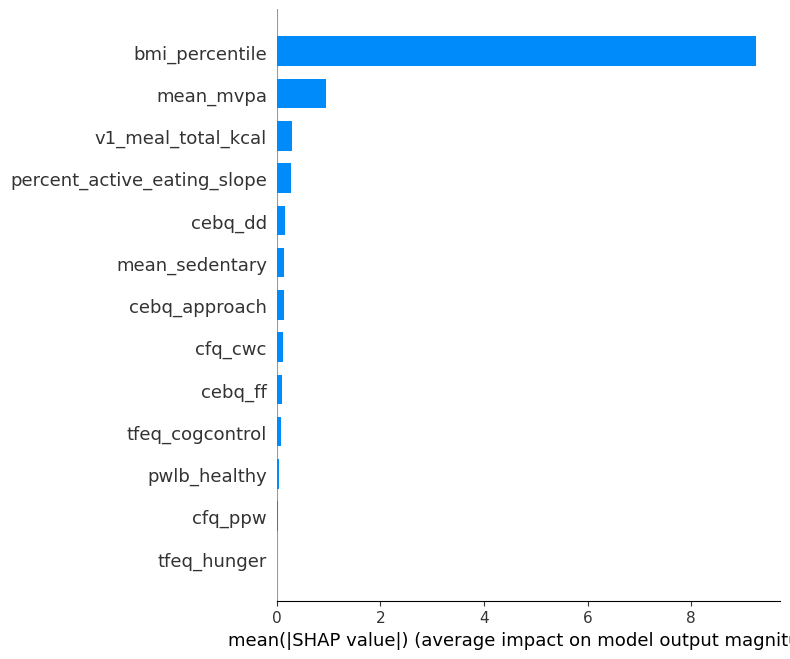

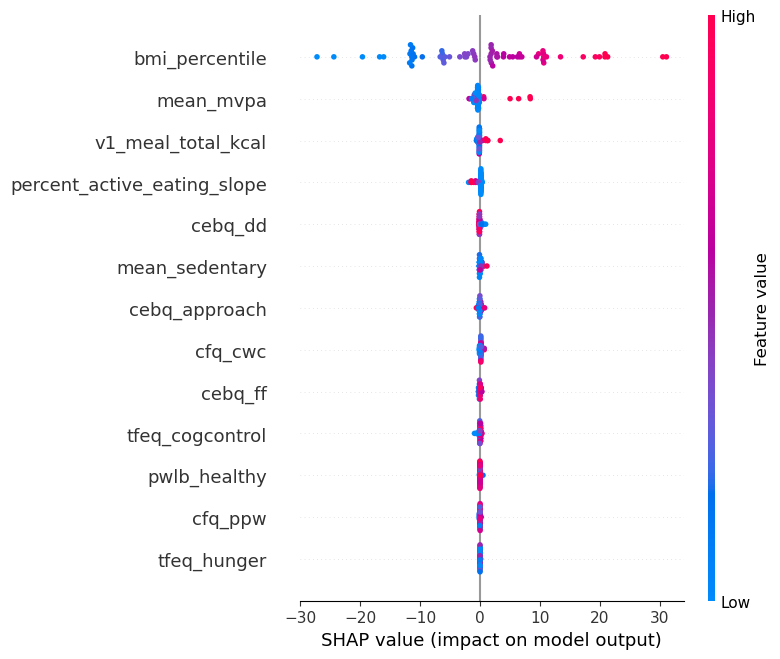

In [77]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load test data and model
df = pd.read_csv("test_split_stratified.csv")
df["sex_1"] = df["sex"].map({"Male": 0, "Female": 1})

features_combined = [
    'bmi_percentile', 'mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope',
    'v1_meal_total_kcal', 'cebq_dd', 'cebq_ff', 'cebq_approach',
    'cfq_ppw', 'cfq_cwc', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_hunger'
]
X = df[features_combined]

# Load model
model = joblib.load("xgb_model_bmi_combined.pkl")

# Compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP bar plot
shap.summary_plot(shap_values, X, plot_type="bar")

# SHAP beeswarm plot
shap.summary_plot(shap_values, X)

## Residual Plots

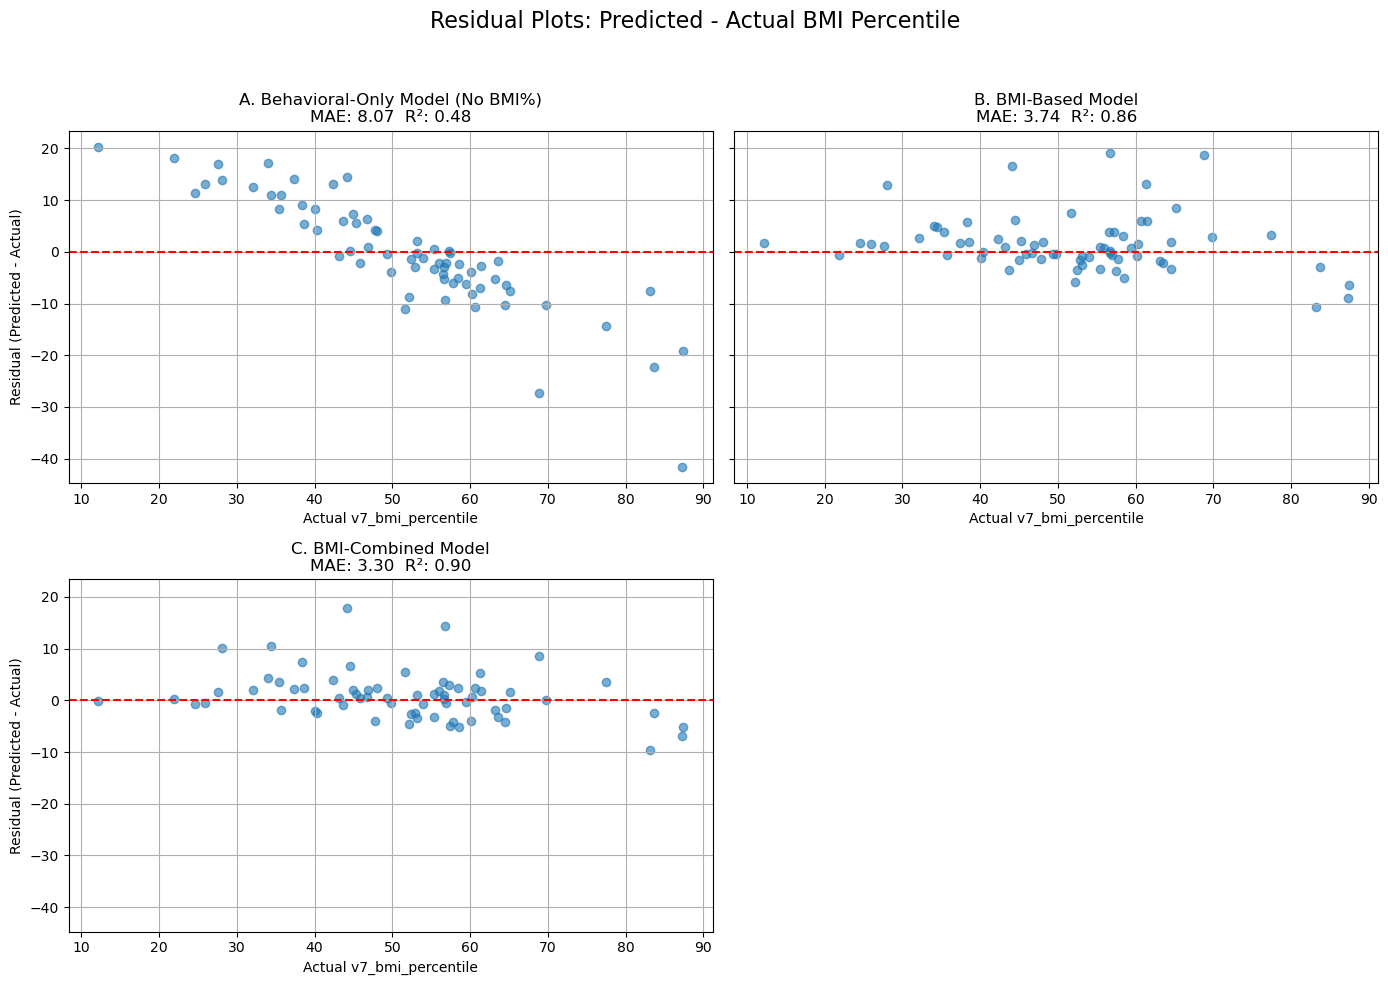

In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Load test data ---
test_df = pd.read_csv("test_split_stratified.csv")
test_df["sex_1"] = test_df["sex"].map({"Male": 0, "Female": 1})

# --- Define target ---
target = "v7_bmi_percentile"
y = test_df[target]

# --- Define model configs with correct filenames ---
model_configs = {
    "A": {
        "name": "Behavioral-Only Model (No BMI%)",
        "features": [
            'mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope',
            'v1_meal_total_kcal', 'cebq_dd', 'cebq_ff', 'cebq_approach',
            'cfq_ppw', 'cfq_cwc', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_hunger'
        ],
        "model_path": "xgb_behavior_model_without_bmi.pkl"
    },
    "B": {
        "name": "BMI-Based Model",
        "features": ['bmi_percentile', 'mean_mvpa', 'bas_drive'],
        "model_path": "xgb_model_with_bmi.pkl"
    },
    "C": {
        "name": "BMI-Combined Model",
        "features": [
            'bmi_percentile', 'mean_mvpa', 'mean_sedentary', 'percent_active_eating_slope',
            'v1_meal_total_kcal', 'cebq_dd', 'cebq_ff', 'cebq_approach',
            'cfq_ppw', 'cfq_cwc', 'pwlb_healthy', 'tfeq_cogcontrol', 'tfeq_hunger'
        ],
        "model_path": "xgb_model_bmi_combined.pkl"
    }
}

# --- Create 2x2 residual plots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
fig.suptitle("Residual Plots: Predicted - Actual BMI Percentile", fontsize=16)

# Flatten axes for easy indexing
axes_flat = axes.flatten()

# Plot each model
for idx, (label, cfg) in enumerate(model_configs.items()):
    model = joblib.load(cfg["model_path"])
    X = test_df[cfg["features"]]
    y_pred = model.predict(X)
    residuals = y_pred - y

    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)

    ax = axes_flat[idx]
    ax.scatter(y, residuals, alpha=0.6)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title(f"{label}. {cfg['name']}\nMAE: {mae:.2f}  R²: {r2:.2f}")
    ax.set_xlabel("Actual v7_bmi_percentile")
    if idx in [0, 2]:  # Left column
        ax.set_ylabel("Residual (Predicted - Actual)")
    ax.grid(True)

# Hide the unused 4th subplot (bottom right)
axes_flat[-1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()